<a href="https://colab.research.google.com/github/ZhongyuGuo/M4R/blob/main/lstm_classficaltion_2cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
import keras
import random
import re

In [2]:
from google.colab import drive
drive.mount("/content/drive")
df=pd.read_csv("/content/drive/My Drive/M4R/papers2019_200000.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# List of categories
catlist=['math','cs','quant-ph','hep-ex','hep-th','astro-ph','nucl-ex','nucl-th']

In [4]:
# Categories to classify
cat1=catlist[6]
cat2=catlist[7]

In [5]:
# Obtain corresponding abstarcts
df1=df[df['categories']==cat1][0:1500].reset_index(drop=True)
df2=df[df['categories']==cat2][0:1500].reset_index(drop=True)
text=df1.append(df2).reset_index(drop=True)

In [6]:
RANDOM_STATE = 50
EPOCHS =15
BATCH_SIZE = 256
TRAINING_LENGTH = 50
TRAIN_FRACTION = 0.7
LSTM_CELLS = 64
VERBOSE = 1
SAVE_MODEL = True

In [7]:
def format_text(text):
    """Add spaces around punctuation and remove references to images/citations."""

    # Add spaces around punctuation
    text = re.sub(r'(?<=[^\s0-9])(?=[.,;?])', r' ', text)

    # Remove references to figures
    text = re.sub(r'\((\d+)\)', r'', text)


    # Remove meaningless words
    text = re.sub(' the ',' ',text)
    text = re.sub(' of ',' ',text)
    text = re.sub(' and ',' ',text)
    text = re.sub(' a ',' ',text)
    text = re.sub(' in ',' ',text)
    text = re.sub(' to ',' ',text)
    text = re.sub(' with ',' ',text)
    text = re.sub(' for ',' ',text)
    text = re.sub(' by ',' ',text)
    text = re.sub(' on ',' ',text)
    text = re.sub(' as ',' ',text)
    text = re.sub(' an ',' ',text)
    text = re.sub(' at ',' ',text)
    text = re.sub(' we ',' ',text)
    text = re.sub(' is ',' ',text)
    text = re.sub(' this ',' ',text)
    text = re.sub(' are ',' ',text)
    text = re.sub(' which ',' ',text)
    text = re.sub(' be ',' ',text)
    text = re.sub(' it ',' ',text)
    text = re.sub(' that ',' ',text)
    text = re.sub(' from ',' ',text)
    text = re.sub(' can ',' ',text)
    text = re.sub(' these ',' ',text)
    text = re.sub(' our ',' ',text)
    text = re.sub(' has ',' ',text)
    text = re.sub(' have ',' ',text)
    text = re.sub('.We ','.',text)
    text = re.sub('.That ','.',text)
    text = re.sub('.The ','.',text)
    text = re.sub('.From ','.',text)
    text = re.sub('.Our ','.',text)
    text = re.sub('.In ','.',text)
    text = re.sub('.These ','.',text)
    text = re.sub('.This ','.',text)
    text = re.sub(',that ',',',text)

    # Remove double spaces
    text = re.sub(r'\s\s', ' ', text)
    
    return text

In [8]:
formatted = []

# Iterate through all the original abstracts
for a in text['abstracts']:
    formatted.append(format_text(a))

In [9]:
def make_sequences(texts,training_length=50,lower=True,
                   filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
    """Turn a set of texts into sequences of integers"""

    # Create the tokenizer object and train on texts
    tokenizer = Tokenizer(lower=lower, filters=filters)
    tokenizer.fit_on_texts(texts)

    # Create look-up dictionaries and reverse look-ups
    word_idx = tokenizer.word_index
    idx_word = tokenizer.index_word
    num_words = len(word_idx) + 1
    word_counts = tokenizer.word_counts

    print(f'There are {num_words} unique words.')

    # Convert text to sequences of integers
    features = tokenizer.texts_to_sequences(texts)

    categories=list(set(text['categories'].values))
    # Make labels
    labels=np.zeros((len(text),len(categories)))
    for i in range(len(text)):
      ind = categories.index(text.iloc[i,1])
      labels[i,ind]=1
    return word_idx, idx_word, num_words, word_counts, features,labels


In [10]:
TRAINING_LENGTH = 50
filters = '.,!"#$%&()*+/:<=>@[\\]^_`{|}~\t\n'
word_idx, idx_word, num_words, word_counts,features,labels = make_sequences(
    formatted, TRAINING_LENGTH, lower=True, filters=filters)

There are 14260 unique words.


In [11]:
#Make all sequences to same length
pad = len(max(features, key=len))
features=[i + [0]*(pad-len(i)) for i in features]
# Reshape to an array
features1=np.array(features)

In [12]:
# Define Training and Test sets
X_input=np.zeros([2000,len(features[0])])
X_input[0:1000,:]=features1[0:1000,:]
X_input[1000:2000]=features1[1500:2500,:]
X_test=np.zeros([1000,len(features[0])])
X_test[0:500,:]=features1[1000:1500,:]
X_test[500:1000]=features1[2500:3000,:]

y_input=np.zeros([2000,2])
y_input[0:1000,:]=labels[0:1000,:]
y_input[1000:2000]=labels[1500:2500]
y_test=np.zeros([1000,2])
y_test[0:500,:]=labels[1000:1500,:]
y_test[500:1000]=labels[2500:3000,:]

In [13]:
from sklearn.utils import shuffle


def create_train_valid(features,
                       labels,
                       train_fraction=TRAIN_FRACTION):
    # Create training and validation features and labels

    # Randomly shuffle features and labels
    features, labels = shuffle(features, labels, random_state=RANDOM_STATE)

    # Decide on number of samples for training
    train_end = int(train_fraction * len(labels))

    train_features = np.array(features[:train_end])
    valid_features = np.array(features[train_end:])

    train_labels = labels[:train_end]
    valid_labels = labels[train_end:]

    # Convert to arrays
    X_train, X_valid = np.array(train_features), np.array(valid_features)
    y_train, y_valid = np.array(train_labels), np.array(valid_labels)

    # Memory management
    import gc
    gc.enable()
    del features, train_features, labels, valid_features, train_labels, valid_labels
    gc.collect()

    return X_train, X_valid, y_train, y_valid

In [14]:
X_train, X_valid, y_train, y_valid = create_train_valid(X_input, y_input)

In [15]:
# Load in GloVe
glove=np.loadtxt('/content/drive/My Drive/M4R/glove.6B.100d.txt',dtype='str', comments=None)

In [16]:
# Split words from vector representation
vectors = glove[:, 1:].astype('float')
words = glove[:, 0]
del glove

In [17]:
word_lookup = {word: vector for word, vector in zip(words, vectors)}

embedding_matrix = np.zeros((num_words, vectors.shape[1]))

not_found = 0

for i, word in enumerate(word_idx.keys()):
    # Look up the word embedding
    vector = word_lookup.get(word, None)

    # Record in matrix
    if vector is not None:
        embedding_matrix[i + 1, :] = vector
    else:
        not_found += 1

print(f'There were {not_found} words without pre-trained embeddings.')

There were 5179 words without pre-trained embeddings.


In [18]:
import gc
gc.enable()
del vectors
gc.collect()

153

In [19]:
# Normalize and convert nan to 0
embedding_matrix = embedding_matrix / \
    np.linalg.norm(embedding_matrix, axis=1).reshape((-1, 1))
embedding_matrix = np.nan_to_num(embedding_matrix)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [20]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

In [21]:
def make_word_level_model(embedding_matrix,
                          lstm_cells=64,
                          trainable=False,
                          lstm_layers=1,
                          bi_direc=False):
    """Make a word level recurrent neural network with option for pretrained embeddings
       and varying numbers of LSTM cell layers."""

    model = Sequential()

    # Map words to an embedding
    if not trainable:
        model.add(
            Embedding(
                input_dim=num_words,
                output_dim=embedding_matrix.shape[1],
                weights=[embedding_matrix],
                trainable=False,
                mask_zero=True))
        model.add(Masking())
    else:
        model.add(
            Embedding(
                input_dim=num_words,
                output_dim=embedding_matrix.shape[1],
                weights=[embedding_matrix],
                trainable=True))

    # If want to add multiple LSTM layers
    if lstm_layers > 1:
        for i in range(lstm_layers - 1):
            model.add(
                LSTM(
                    lstm_cells,
                    return_sequences=True,
                    dropout=0.1,
                    recurrent_dropout=0.1))

    # Add final LSTM cell layer
    model.add(
        LSTM(
            lstm_cells,
            return_sequences=False,
            dropout=0.1,
            recurrent_dropout=0.1))
    model.add(Dense(128, activation='relu'))
    # Dropout for regularization
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(len(labels[0]), activation='softmax'))

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model


model = make_word_level_model(
    embedding_matrix=embedding_matrix,
    lstm_cells=LSTM_CELLS,
    trainable=False,
    lstm_layers=1,
    bi_direc=False)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1426000   
_________________________________________________________________
masking (Masking)            (None, None, 100)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 1,476,818
Trainable params: 50,818
Non-trainable params: 1,426,000
_________________________________________

In [22]:
from IPython.display import Image
model_name = 'pre-trained-rnn'
model_dir = '../models/'
# Plot model is no is functioning due to updeates of Keras
#plot_model(model,show_shapes=True)

In [23]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Implement early stopping and save model
def make_callbacks(model_name, save=SAVE_MODEL):
    """Make list of callbacks for training"""
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

    if save:
        callbacks.append(
            ModelCheckpoint(
                f'/content/drive/My Drive/M4R/123.h5',
                save_best_only=True,
                save_weights_only=False))
    return callbacks


callbacks = make_callbacks(model_name,SAVE_MODEL)

In [24]:
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    callbacks=callbacks,
    validation_data=(X_valid, y_valid))

Epoch 1/15
6/6 [==============================] - 40s 2s/step - loss: 0.6922 - accuracy: 0.5068 - val_loss: 0.6864 - val_accuracy: 0.5167
Epoch 2/15
6/6 [==============================] - 9s 2s/step - loss: 0.6845 - accuracy: 0.5837 - val_loss: 0.6728 - val_accuracy: 0.6700
Epoch 3/15
6/6 [==============================] - 9s 2s/step - loss: 0.6654 - accuracy: 0.6467 - val_loss: 0.6236 - val_accuracy: 0.6650
Epoch 4/15
6/6 [==============================] - 9s 2s/step - loss: 0.5828 - accuracy: 0.7241 - val_loss: 0.4587 - val_accuracy: 0.8167
Epoch 5/15
6/6 [==============================] - 9s 2s/step - loss: 0.5269 - accuracy: 0.7850 - val_loss: 0.4429 - val_accuracy: 0.8067
Epoch 6/15
6/6 [==============================] - 10s 2s/step - loss: 0.4635 - accuracy: 0.8105 - val_loss: 0.4235 - val_accuracy: 0.8417
Epoch 7/15
6/6 [==============================] - 9s 2s/step - loss: 0.4389 - accuracy: 0.8205 - val_loss: 0.3878 - val_accuracy: 0.8450
Epoch 8/15
6/6 [=======================

In [25]:
# Load and evaluate model
def load_and_evaluate(model_name, return_model=False):
    """Load in a trained model and evaluate with log loss and accuracy"""

    model = load_model(f'/content/drive/My Drive/M4R/123.h5')

    loss, acc = model.evaluate(X_valid, y_valid, batch_size=BATCH_SIZE, verbose=1)
    print('Validation Loss: {}'.format(loss))
    print('Validation Accuracy: {}'.format(acc*100))

    test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=1)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc*100))

    if return_model:
        return model

In [26]:
model = load_and_evaluate(model_name, return_model=True)

3/3 [==============================] - 2s 130ms/step - loss: 0.3219 - accuracy: 0.8717
Validation Loss: 0.3218662440776825
Validation Accuracy: 87.1666669845581
4/4 [==============================] - 1s 123ms/step - loss: 0.3872 - accuracy: 0.8430
Test Loss: 0.38716602325439453
Test Accuracy: 84.29999947547913


In [27]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.7105939641594887)

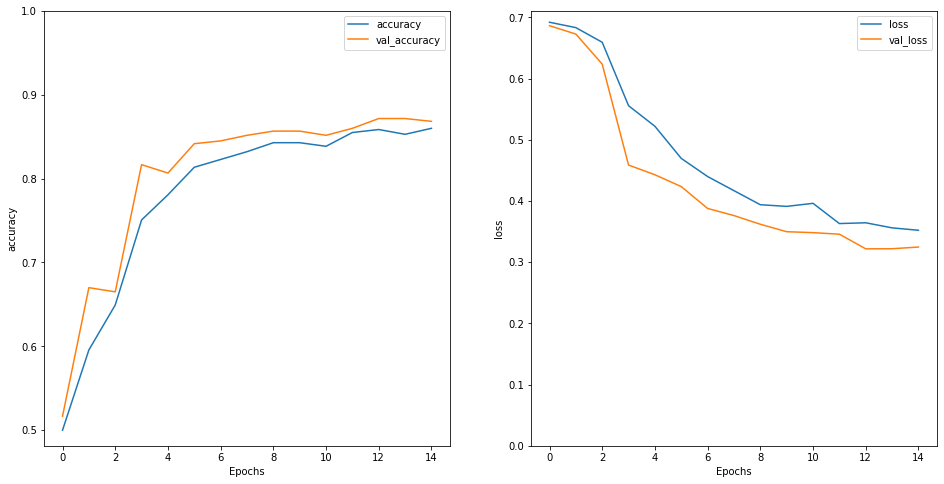

In [28]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

In [29]:
# Find probability matrix of text data
prob=model.predict(X_test)
diff=[]
# Find the abstarct that has the closest probabilities
for i in range(len(prob)):
  diff.append(np.abs(prob[i,0]-prob[i,1]))
ind=diff.index(min(diff))
if ind<=500:
  print(df1.iloc[1000+ind,:])
  print(df1.iloc[1000+ind,:]['abstracts'])
if ind>=500:
  print(df1.iloc[1000+ind-500,:])
  print(df2.iloc[1000+ind-500,:]['abstracts'])

Unnamed: 0                                               173146
categories                                              nucl-ex
abstracts       PHENIX has measured direct photons in p+p an...
year                                                       2019
Name: 1274, dtype: object
  Excited states in the deformed nucleus $^{158}$Gd have been studied in the (p,t) reaction by using the Munich Tandem and Q3D spectrograph. 30 new excited 0$^+$ states (three tentative) have been assigned up to the 4.3 MeV excitation energy. The total number of 34 excited 0$^+$ states (four tentatively assigned) in a deformed nucleus, close to a complete level scheme, offers a new opportunity to test nuclear models and obtain more information on the structure of these special states. 


In [30]:
# Show the probabilities
print(prob[ind,:])

[0.5034003  0.49659967]
